# UDS emulator 

## Preliminaries

In [1]:
from my_imports import *

The current branch is: Clean_and_refactor


In [6]:
yaml_path = 'config_file.yaml'
yaml_data = utils.load_yaml(yaml_path)

training_simulations_path   = yaml_data['training_simulations_path']
validation_simulations_path = yaml_data['validation_simulations_path']

inp_path                    = yaml_data['inp_path']

training_windows_path       = yaml_data['training_windows_path']
use_saved_training_windows  = yaml_data['use_saved_training_windows']

validation_windows_path       = yaml_data['validation_windows_path']
use_saved_validation_windows  = yaml_data['use_saved_validation_windows']

num_events_training     = yaml_data['num_events_training']
num_events_validation   = yaml_data['num_events_validation']

steps_behind            = yaml_data['steps_behind']
steps_ahead             = yaml_data['steps_ahead']
epochs                  = yaml_data['epochs']



## Create simulation objects from data

In [3]:
list_of_training_simulations    = os.listdir(training_simulations_path)
list_of_validation_simulations  = os.listdir(validation_simulations_path)

random.shuffle(list_of_training_simulations)

print('Number of training simulations: ', len(list_of_training_simulations))
print('Number of validation simulations: ', len(list_of_validation_simulations))


Number of training simulations:  161
Number of validation simulations:  29


In [7]:
training_simulations = utils.extract_simulations_from_folders(training_simulations_path, inp_path, num_events_training)
if use_saved_training_windows:
    training_windows = utils.load_windows(training_windows_path)
else:
    training_windows = utils.get_all_windows_from_list_simulations(training_simulations, steps_ahead)

The file does not have [STORAGE]

The file does not have '[PUMPS]\n'
The file does not have '[ORIFICES]\n'
The file does not have '[WEIRS]\n'
Using loaded windows from:  C:\Users\agarzondiaz\surfdrive\Year 2\Paper 2 - 3.0\pickles\training_windows_50_events_4_steps.pk


In [8]:
validation_simulations = utils.extract_simulations_from_folders(validation_simulations_path, inp_path, num_events_validation)
if use_saved_validation_windows:
    validation_windows = utils.load_windows(validation_windows_path)
else:
    validation_windows = utils.get_all_windows_from_list_simulations(validation_simulations, steps_ahead = 115)

The file does not have [STORAGE]

The file does not have '[PUMPS]\n'
The file does not have '[ORIFICES]\n'
The file does not have '[WEIRS]\n'
Using loaded windows from:  C:\Users\agarzondiaz\surfdrive\Year 2\Paper 2 - 3.0\pickles\validation_windows_5_events_4_steps.pk


In [9]:
print('Number of training windows: ',   len(training_windows))
print('Number of validation windows: ', len(validation_windows))

Number of training windows:  3824
Number of validation windows:  259


## Normalizer

In [10]:
normalizer = Normalizer(training_windows)

In [13]:
normalized_training_windows = normalizer.get_list_normalized_training_windows()
training_loader = DataLoader(normalized_training_windows, batch_size=32, shuffle = True)

In [14]:
normalized_validation_windows = [normalizer.normalize_window(val_win) for val_win in validation_windows]
validation_loader = DataLoader(normalized_validation_windows, batch_size=32)

## Training GNN

In [16]:
gnn_model = GNNModel()
# gnn_model.load_state_dict(torch.load('saved_objects/model_trained_4steps.pt'))

optimizer = optim.Adam(gnn_model.parameters(), lr = 0.01)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
loss_fn   = nn.MSELoss()

In [ ]:
history = train(
    model       = gnn_model,
    optimizer   = optimizer,
    scheduler   = scheduler,
    loss_fn     = loss_fn,
    train_dl    = training_loader,
    val_dl      = validation_loader,
    epochs      = epochs,
    device      = 'cpu',
    report_freq = 2
    )

In [ ]:
torch.save(gnn_model.state_dict(), 'saved_objects/trained_model_{}_steps.pt'.format(steps_ahead))

In [ ]:
vis.plot_loss(history)

## Using the GNN

In [17]:
val_event =  validation_simulations[-1]
print(val_event)

sim_in_window       = val_event.get_simulation_in_one_window()

norm_sim_in_window  = normalizer.normalize_window(sim_in_window)

swmm_heads_pd       = normalizer.get_unnormalized_heads_pd(sim_in_window['y']) 
predicted_heads_pd  = normalizer.get_unnormalized_heads_pd(gnn_model(norm_sim_in_window))

SWMMSimulation(synt_94)


<AxesSubplot:>

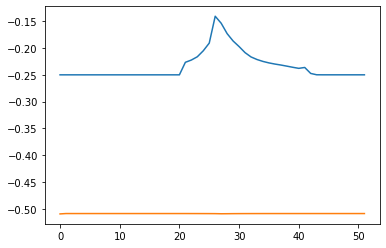

In [34]:
node = name_nodes[20]

swmm_heads_pd[node].plot()
predicted_heads_pd[node].plot()

## Visualization of results

In [ ]:
target      = normalizer.unnormalize_heads(norm_sim_in_window.y)
predicted   = normalizer.unnormalize_heads(gnn_model(norm_sim_in_window).detach())

In [ ]:
pd.DataFrame(target[-1,:].numpy()).plot()
pd.DataFrame(predicted[-1,:].numpy()).plot()

In [ ]:
importlib.reload(vis)

In [ ]:
error = torch.abs(target - predicted)
fig = vis.plot_nodal_variable(error, norm_sim_in_window, 'error in head (m) ', colorscale = 'OrRd')


In [ ]:
norm_sim_in_window.name_nodes[0]

In [ ]:
# fig.write_html('error.html')

In [ ]:
fig = vis.plot_nodal_variable(target, norm_sim_in_window, 'Target Head ', colorscale = 'PuBu', ref_marker_size = 2.5)

# Scratchpad (old)

In [ ]:
zero_cases_simulations_path = yaml_data['zero_cases_simulations_path']
list_of_zero_cases_simulations  = os.listdir(zero_cases_simulations_path)

zero_cases_simulations = utils.extract_simulations_from_folders(zero_cases_simulations_path, inp_path, max_events = 2)


In [ ]:
gnn_model = GNNModel()

In [ ]:
sim_trial = zero_cases_simulations[0]

length = sim_trial.simulation_length
sim_in_window = sim_trial.get_all_windows(steps_ahead = length-2)[0]
norm_sim_in_window = normalizer.normalize_window(sim_in_window)

name_nodes = norm_sim_in_window.name_nodes

swmm_heads_pd       = utils.tensor_heads_to_normalized_pd(sim_in_window['y'],             normalizer, name_nodes)
predicted_heads_pd  = utils.tensor_heads_to_normalized_pd(gnn_model(norm_sim_in_window),  normalizer, name_nodes)

In [ ]:
target      = normalizer.unnormalize_heads(norm_sim_in_window.y)
predicted   = normalizer.unnormalize_heads(gnn_model(norm_sim_in_window).detach())

In [ ]:
pd.DataFrame(target[-1,:].numpy()).plot()
pd.DataFrame(predicted[-1,:].numpy()).plot()

In [ ]:
error = torch.abs(target - predicted)
fig = vis.plot_nodal_variable(error, norm_sim_in_window, 'error in head at time: ', colorscale = 'OrRd')

In [ ]:
norm_sim_in_window.name_nodes[0]

In [ ]:
# fig.write_html('error.html')

In [ ]:
fig = vis.plot_nodal_variable(target, norm_sim_in_window, 'Target Head ', colorscale = 'PuBu', ref_marker_size = 2.5)

# Scratchpad (new)

In [ ]:
val_event =  validation_simulations[17]
event_in_windows = val_event.get_all_windows(steps_ahead=1)
print(val_event.name_simulation)

In [ ]:
norm_event_in_windows = [normalizer.normalize_window(window) for window in event_in_windows]

In [ ]:
results = []
for i in norm_event_in_windows:
    results.append(gnn_model(i))

In [ ]:
prediction = torch.cat(results, axis = 1)
unnormalized_prediction = normalizer.unnormalize_heads(prediction)

In [ ]:
val_event =  validation_simulations[17]

length = val_event.simulation_length
sim_in_window = val_event.get_all_windows(steps_ahead = length-2)[0]
norm_sim_in_window = normalizer.normalize_window(sim_in_window)

name_nodes = norm_sim_in_window.name_nodes

swmm_heads_pd       = utils.tensor_heads_to_normalized_pd(sim_in_window['y'],             normalizer, name_nodes)

In [ ]:
name_nodes =norm_sim_in_window.name_nodes

In [ ]:
name_nodes.index('j_90507') #j_90450

In [ ]:
rollout_results = gnn_model(norm_sim_in_window)
unnormalized_rollout = normalizer.unnormalize_heads(rollout_results)

In [ ]:
node = np.random.randint(0, 300)

print('Node: ', node, 'ID: ', name_nodes[node])
pd.DataFrame(unnormalized_prediction[node,:].detach().numpy()).plot()
swmm_heads_pd.iloc[:,node].plot()


import matplotlib.pyplot as plt
a = pd.DataFrame(unnormalized_rollout[node,:].detach().numpy())
b = pd.DataFrame(swmm_heads_pd.iloc[:,node])

fig, ax = plt.subplots()

ax.plot(a)
ax.plot(b)

plt.show()

In [ ]:
val_event.name_simulation